# Notebook to Investigate LSTM Performance Variance for Montane Only Single Snow Type Model 

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {} 
run_dict["Mon_Base"] = "205a7c93718f49428a0d34a6f281586c" # done
run_dict["Mon_DI_30"] = "e40ba503de2a47cd90275572882dbffd" # done
run_dict["Mon_DI_30_redo"] = "f281b104cf1747d98187f0a90dbac890" # 23
run_dict["Mon_DI_7"] = "dfbbbe14fe174a87866504850b38267d" #28
run_dict["Mon_hum"] = "f344df14033f4a1caf9baede0c2e05f3" # done 
run_dict



{'Mon_Base': '205a7c93718f49428a0d34a6f281586c',
 'Mon_DI_30': 'e40ba503de2a47cd90275572882dbffd',
 'Mon_DI_30_redo': 'f281b104cf1747d98187f0a90dbac890',
 'Mon_DI_7': 'dfbbbe14fe174a87866504850b38267d',
 'Mon_hum': 'f344df14033f4a1caf9baede0c2e05f3'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
#key = "Elev_and_FC_30"
key = "Mon_DI_30_redo"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics.head(2)


(10576, 3)


,Metric,Step,Value
0,test_mse_170602080601,0,0.001351
1,test_mse_170602080601,1,0.005165


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

# Step 3 - Define Some Plotting Functions

In [8]:
def plot_step_metrics(df, title='Metrics vs Step', save = True):
    """Plots all columns in the given DataFrame against the index with a legend."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each column
    for column in df.columns:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()


In [9]:
def plot_median_comparison(df_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = True):
    """Plots the 'median' column against the index for each DataFrame in the dictionary."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each DataFrame
    for label, df in df_dict.items():
        plt.plot(df.index, df['median'], marker='o', linestyle='-', label=label)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Median Value')
    plt.title(title)
    #plt.ylim(-1, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()

# Step 4 Examine Test-KGE For An Example Run 

In [10]:
df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
summary = df_filtered.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
summary

,median,mean,min,max,std
Step,,,,,
0,0.886201,0.871735,0.631816,0.971189,0.070145
1,0.528819,0.516730,-0.020876,0.901554,0.189429
2,0.628182,0.633069,0.007230,0.961339,0.206457
3,0.805379,0.770413,0.132276,0.973413,0.180137
4,0.836117,0.790080,0.172281,0.980592,0.176135
5,0.845989,0.774920,0.180227,0.970056,0.201521
6,0.823676,0.738953,0.083970,0.958363,0.218537
7,0.784894,0.739128,0.230841,0.972220,0.171106
8,0.832509,0.761851,-0.010818,0.982222,0.215946


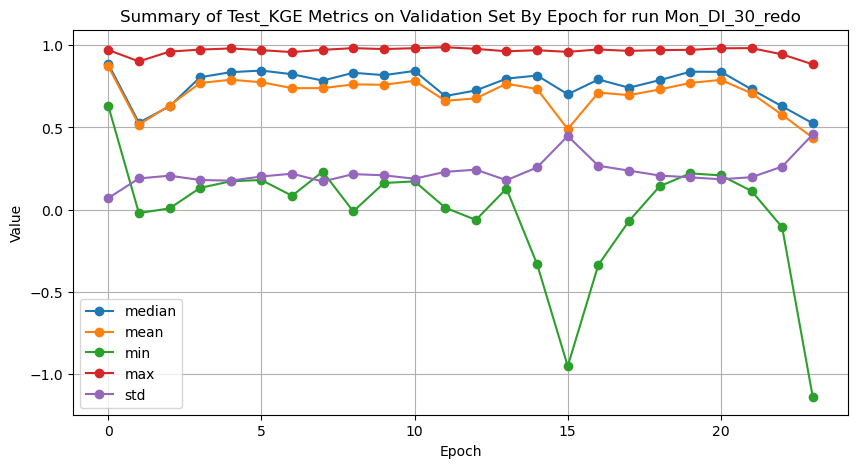

In [11]:
ttl = f"Summary of Test_KGE Metrics on Validation Set By Epoch for run {key}"
plot_step_metrics(summary, title = ttl, save = False)

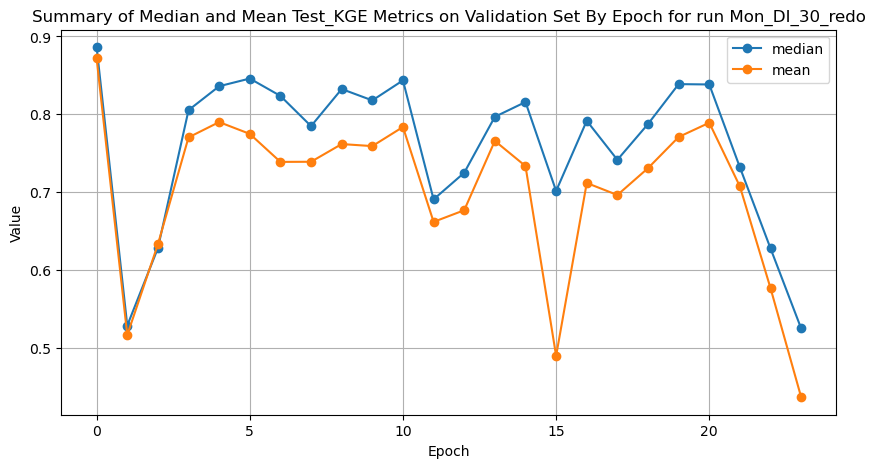

In [12]:
# zoom in on just the median and the mean
ttl = f"Summary of Median and Mean Test_KGE Metrics on Validation Set By Epoch for run {key}" 
summary_slim = summary[["median", "mean"]]
plot_step_metrics(summary_slim, title = ttl, save = False)

# Step 4B - Test Recur KGE for a Sample Run

In [13]:

df_filtered_recur = extract_metric_by_prefix(df_metrics, "test_recur_kge", step=True)
summary_recur = df_filtered_recur.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
summary_recur

,median,mean,min,max,std
Step,,,,,
0,0.463889,0.491345,0.062380,0.932524,0.191493
1,0.643915,0.623981,-0.063236,0.941527,0.236438
2,0.677388,0.657396,0.085379,0.947368,0.177636
3,0.865148,0.796008,0.133077,0.980823,0.189647
4,0.804017,0.768032,0.227677,0.966447,0.169805
5,0.710572,0.652727,-0.167406,0.954225,0.249687
6,0.734063,0.696541,0.077446,0.966741,0.200687
7,0.794042,0.724057,0.083966,0.954513,0.207927
8,0.649330,0.623668,-0.356556,0.974392,0.268528


# Step 5 - Compare Runs

In [14]:
df_summary_dict = {}
for key in run_dict.keys(): 
    df_metrics = df_dict[key]
    df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
    summary_df = df_filtered.groupby("Step")["Value"].agg(["median"])
    df_summary_dict[key] = summary_df

    # KGE Predict Recur    
    df_filtered_recur = extract_metric_by_prefix(df_metrics, "test_recur_kge", step=True)
    summary_recur = df_filtered_recur.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
    if not summary_recur.empty:
        df_summary_dict[key+"+Recur"] = summary_recur
  

In [15]:
def filter_dict(df_summary_dict, excluded_keys):
    return {k: v for k, v in df_summary_dict.items() if k not in excluded_keys}


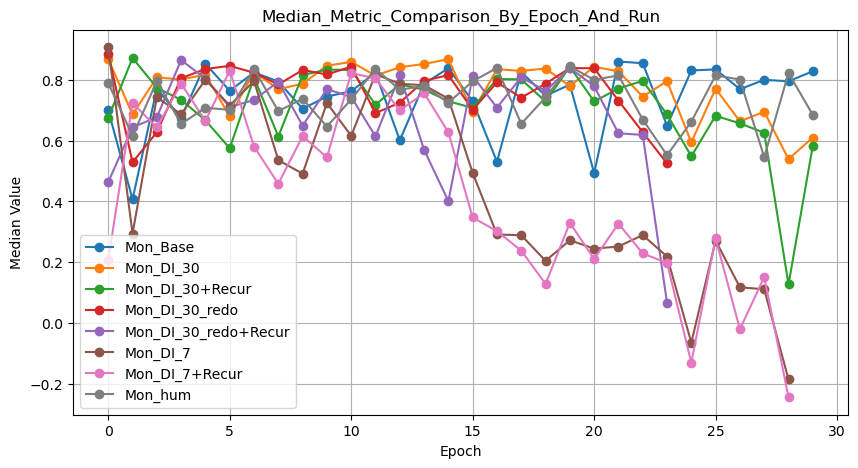

In [16]:
plot_median_comparison(df_summary_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = False)

In [17]:
df_summary_dict.keys()

dict_keys(['Mon_Base', 'Mon_DI_30', 'Mon_DI_30+Recur', 'Mon_DI_30_redo', 'Mon_DI_30_redo+Recur', 'Mon_DI_7', 'Mon_DI_7+Recur', 'Mon_hum'])

In [18]:
excluded_keys = ["Mon_DI_30", "Mon_DI_30_redo", "Mon_DI_7"] 
sum_dict_small = filter_dict(df_summary_dict, excluded_keys)

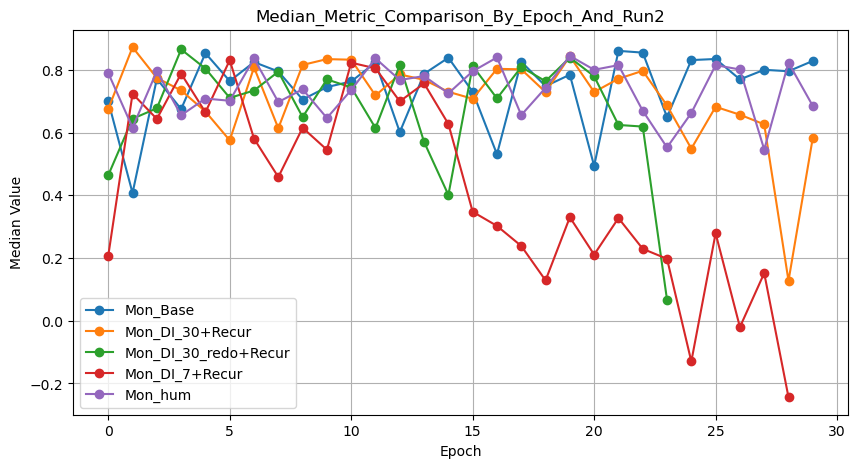

In [19]:
plot_median_comparison(sum_dict_small, title="Median_Metric_Comparison_By_Epoch_And_Run2", save = False)

# Determine max kge for each run 

In [20]:
all_keys = list(df_summary_dict.keys())
for key in all_keys: 
    df = df_summary_dict[key]
    medians = df["median"]
    idx = medians.idxmax()  # Get the index of the max median value
    highest_median = np.max(medians)
    print(f"for run {key} the highest median test kge achieved was {highest_median:.3f} in epoch {idx}")

for run Mon_Base the highest median test kge achieved was 0.860 in epoch 21
for run Mon_DI_30 the highest median test kge achieved was 0.869 in epoch 0
for run Mon_DI_30+Recur the highest median test kge achieved was 0.872 in epoch 1
for run Mon_DI_30_redo the highest median test kge achieved was 0.886 in epoch 0
for run Mon_DI_30_redo+Recur the highest median test kge achieved was 0.865 in epoch 3
for run Mon_DI_7 the highest median test kge achieved was 0.908 in epoch 0
for run Mon_DI_7+Recur the highest median test kge achieved was 0.831 in epoch 5
for run Mon_hum the highest median test kge achieved was 0.844 in epoch 19


# NOtes

For Montane forest multi, lag 30 seems to help slightly.  To do: 
- Run on test hucs?
- Try 60 day recur?
- Make sure predict recur works? 